This notebook requires TomoPy and CIL v24.1.0 or greater

In [33]:
import cil
print(cil.__version__)

24.1.0


In [ ]:
from cil.utilities import dataexample
from cil.processors import PaganinProcessor
from cil.utilities.display import show2D
from cil.recon import FDK, FBP

from tomopy.prep.phase import retrieve_phase
import numpy as np
import matplotlib.pyplot as plt 

The code in this notebook contains some examples and comparisons of using the `PaganinProcessor` phase retrieval methods in CIL 

##### Parallel beam data

In [2]:
# Phase retrieval parameters
delta = 1
beta = 0.002
energy = 40000

In [3]:
# Get data and perform reconstruction without phase retrieval
data = dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()
data.reorder(order='tigre')
data.geometry.config.units = 'um'
data_abs = -1*data.log()
ig = data.geometry.get_ImageGeometry()
fbp =  FBP(data_abs, ig)
recon = fbp.run(verbose=0)

In [4]:
# Run phase retrieval on the raw data and reconstruct
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy)
processor.set_input(data)
thickness = processor.get_output(override_geometry={'propagation_distance':10})
fbp =  FBP(thickness, ig)
recon_thickness = fbp.run(verbose=0)

# calculate mu to get recon_attenuation with the same scaling as the original image
attenuation = thickness*processor.mu
fbp =  FBP(attenuation, ig)
recon_attenuation = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 882.33it/s]


In [5]:
# Run PaganinProcessor as a filter using full_retrieval=False on the absorption data and reconstruct
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, full_retrieval=False)
processor.set_input(data_abs)
filtered_image = processor.get_output(override_geometry={'propagation_distance':10})
fbp =  FBP(filtered_image, ig)
recon_filter = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 2335.20it/s]


In [6]:
# For comparison run Tomopy phase retreival with raw data, then convert to absorption and reconstruct
tomopy_alpha = (1/(delta/beta))/(4*np.pi**2)
data_tomopy = data.copy()
data_tmp = retrieve_phase(data.array, pixel_size=processor.pixel_size, dist=processor.propagation_distance, energy=energy/1000, alpha=tomopy_alpha)
data_tomopy.fill(data_tmp)
data_tomopy = -1*data_tomopy.log()
ig = data_tomopy.geometry.get_ImageGeometry()
fbp =  FBP(data_tomopy, ig)
recon_tomopy = fbp.run(verbose=0)

In [7]:
# And also run Tomopy phase retreival with absorption data and reconstruct
tomopy_alpha = (1/(delta/beta))/(4*np.pi**2)
data_tomopy_abs = data_abs.copy()
data_tmp = retrieve_phase(data_abs.array, pixel_size=processor.pixel_size, dist=processor.propagation_distance, energy=energy/1000, alpha=tomopy_alpha)
data_tomopy_abs.fill(data_tmp)
ig = data_tomopy_abs.geometry.get_ImageGeometry()
fbp =  FBP(data_tomopy_abs, ig)
recon_tomopy_abs = fbp.run(verbose=0)

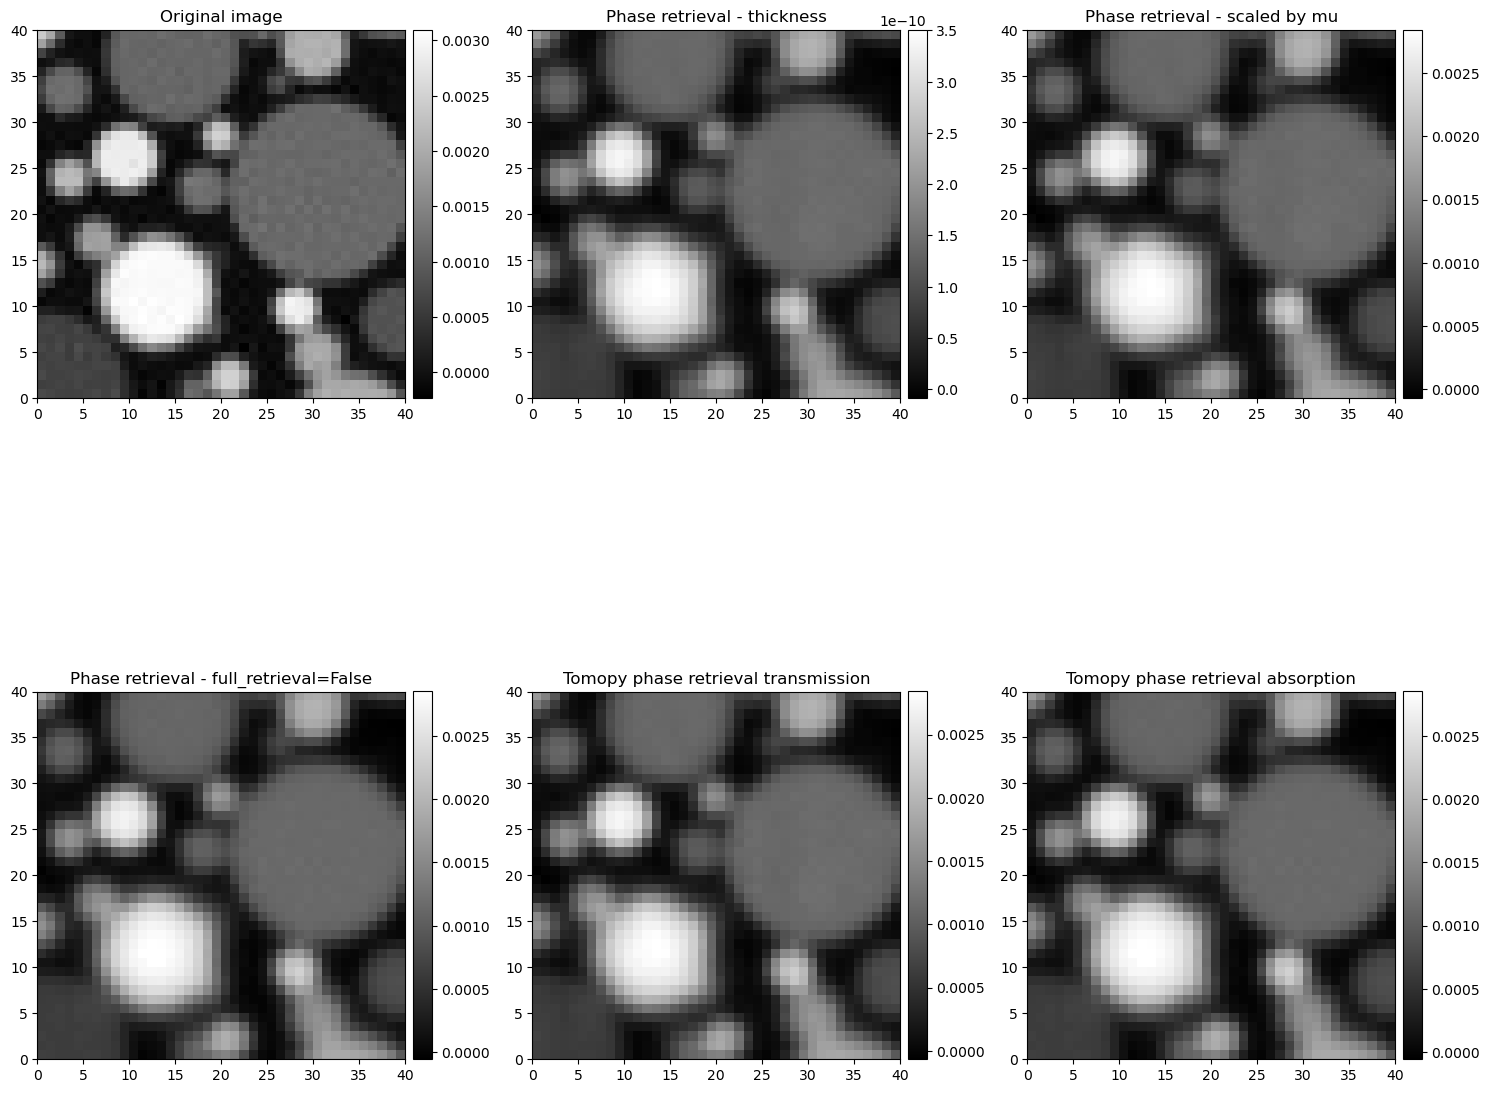

In [8]:
# Compare the outputs
show2D([recon.array[67,50:90,50:90], recon_thickness.array[67,50:90,50:90], recon_attenuation.array[67,50:90,50:90], recon_filter.array[67,50:90,50:90], recon_tomopy.array[67,50:90,50:90], recon_tomopy_abs.array[67,50:90,50:90]],
title=['Original image', 'Phase retrieval - thickness', 'Phase retrieval - scaled by mu', 'Phase retrieval - full_retrieval=False', 'Tomopy phase retrieval transmission', 'Tomopy phase retrieval absorption'], num_cols=3)

Comparing a cross-section, we can see that all methods blur the original image and improve signal to noise. The scaled phase retrieval in CIL matches the Tomopy method performed on transmission data and the filter in CIL matches the Tomopy method performed on absorption data

Text(0, 0.5, 'Intensity')

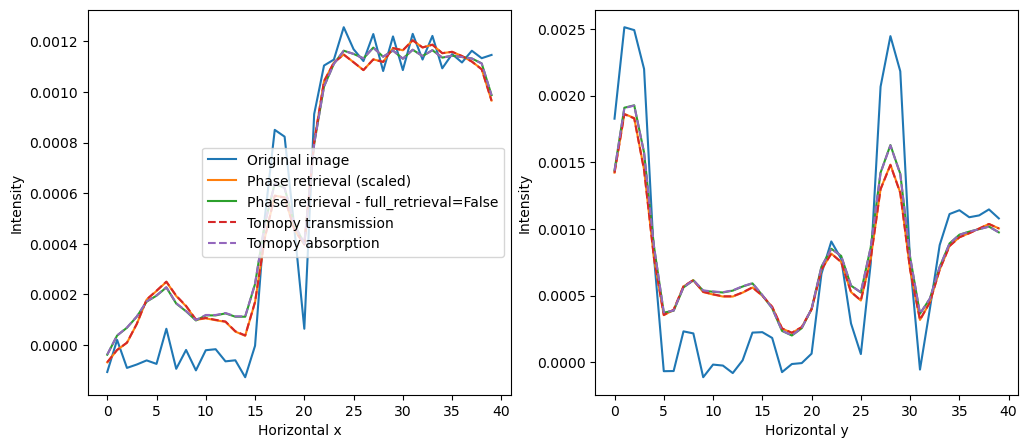

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
ax.plot(recon.array[67,70,50:90])
ax.plot(recon_attenuation.array[67,70,50:90])
ax.plot(recon_filter.array[67,70,50:90])
ax.plot(recon_tomopy.array[67,70,50:90],'--')
ax.plot(recon_tomopy_abs.array[67,70,50:90],'--')

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.legend(['Original image', 'Phase retrieval (scaled)', 'Phase retrieval - full_retrieval=False', 'Tomopy transmission', 'Tomopy absorption'])

ax = axs[1]
ax.plot(recon.array[67,50:90,70])
ax.plot(recon_attenuation.array[67,50:90,70])
ax.plot(recon_filter.array[67,50:90,70])
ax.plot(recon_tomopy.array[67,50:90,70],'--')
ax.plot(recon_tomopy_abs.array[67,50:90,70],'--')

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')

##### Cone beam data

In [10]:
delta = 1
beta = 0.001
energy = 40000

With cone beam data, the magnification $M$ has an effect on the phase retrieval\
$ T = -\frac{1}{\mu}\ln(F^{-1}\frac{F(M^2 I_{norm}(x,y,z=\Delta))}{1+\frac{\Delta\lambda\delta}{4\pi\beta}(k_x^2+k_y^2)/M})$\
The $M^2$ on top means sometimes we get a number larger than 1 inside the $\ln$

In [11]:
# Get data and perform reconstruction without phase retrieval
data = dataexample.SIMULATED_CONE_BEAM_DATA.get()
data.geometry.config.units = 'um'
print(data.geometry.magnification)
data.reorder(order='tigre')
data_abs = -1*data.log()
ig = data.geometry.get_ImageGeometry()
fdk =  FDK(data_abs, ig)
recon = fdk.run(verbose=0)

4.0


In [12]:
# Run phase retrieval on the raw data and reconstruct
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy)
processor.set_input(data)
thickness = processor.get_output()
recon_thickness = fdk.run(verbose=0)
# calculate mu to get recon_attenuation with the same scaling as the original image
attenuation = thickness*processor.mu
fdk =  FDK(attenuation, ig)
recon_attenuation = fdk.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 849.67it/s]


In [13]:
# Run PaganinProcessor as a filter using get_output(full_retrieval=False) on the absorption data and reconstruct
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, full_retrieval=False)
processor.set_input(data_abs)
filtered_image = processor.get_output()

fdk =  FDK(filtered_image, ig)
recon_filter = fdk.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 2349.68it/s]


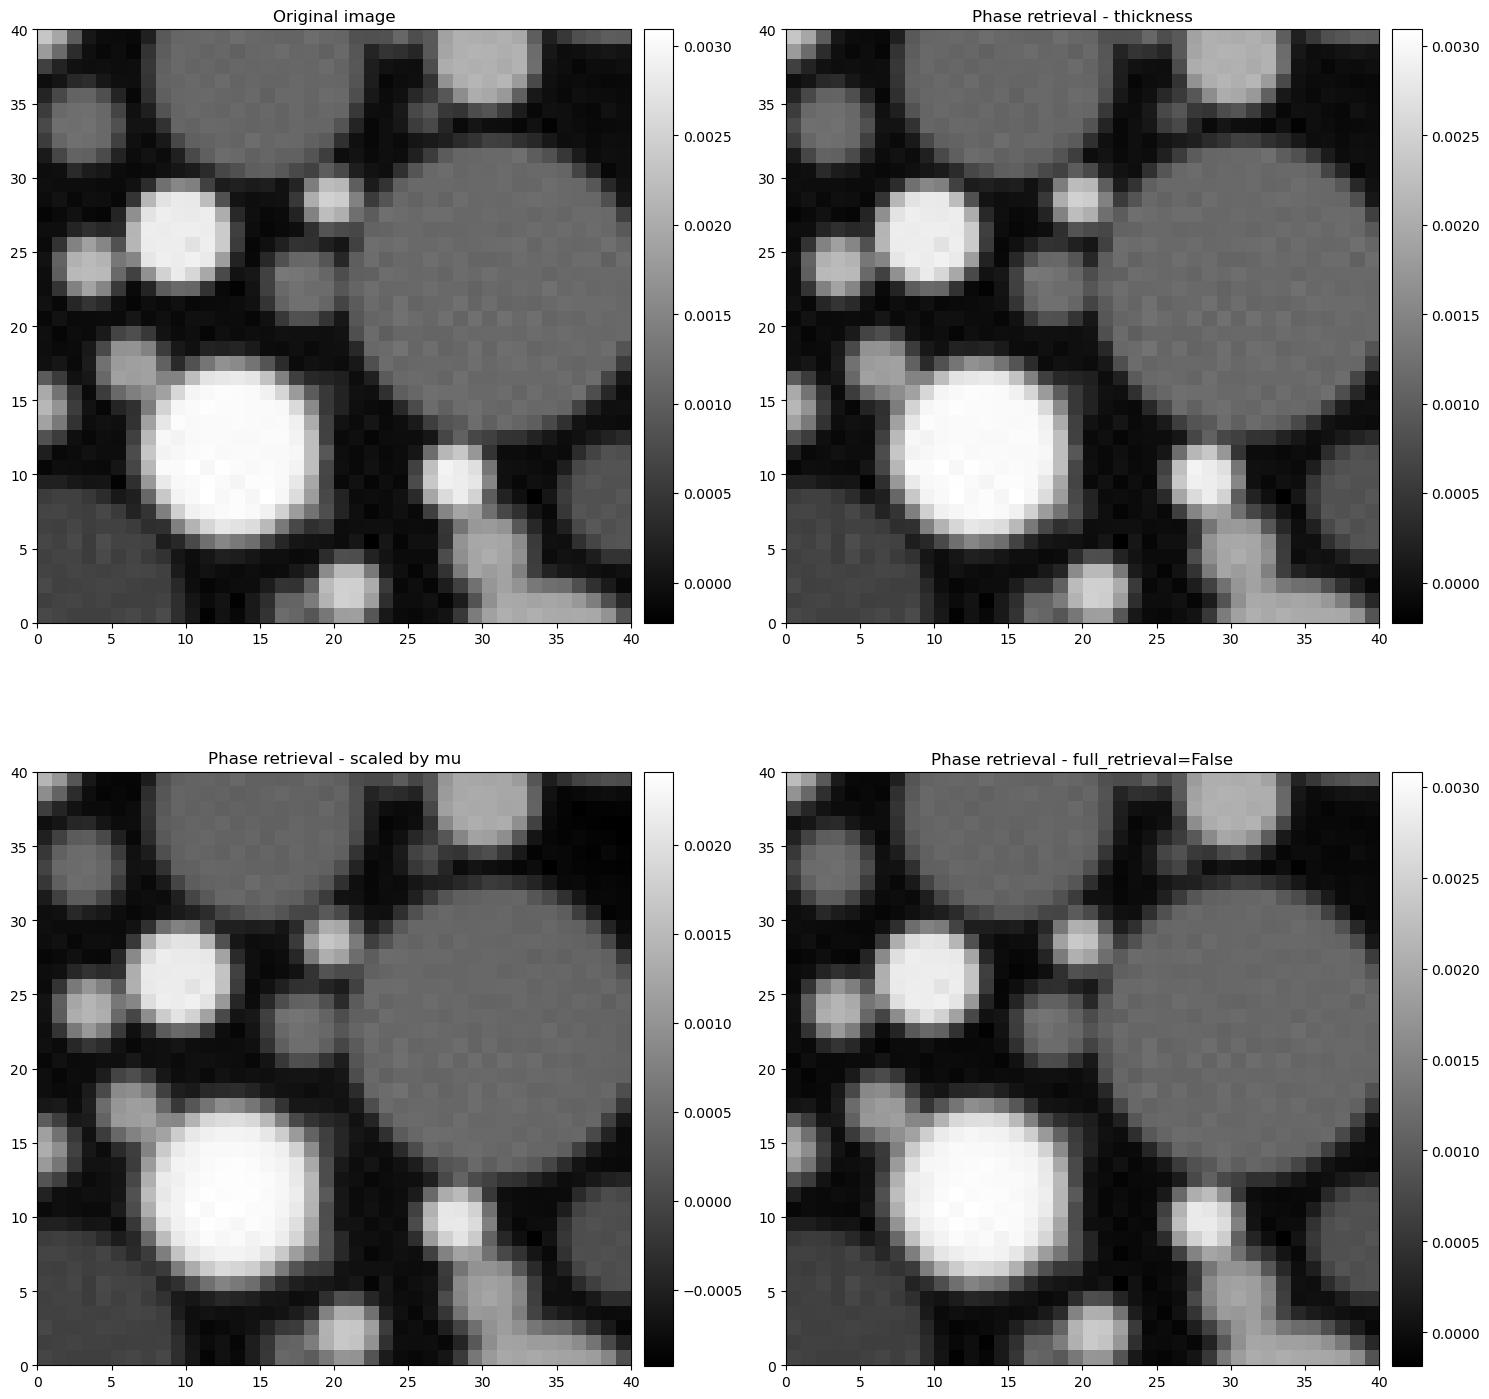

In [14]:
# Compare
show2D([recon.array[67,50:90,50:90], recon_thickness.array[67,50:90,50:90], recon_attenuation.array[67,50:90,50:90], recon_filter.array[67,50:90,50:90]],
title=['Original image', 'Phase retrieval - thickness', 'Phase retrieval - scaled by mu', 'Phase retrieval - full_retrieval=False'])

Comparing a cross-section, we can see that both methods blur the original image and improve signal to noise. The phase retrieval method becomes negative because of the values > 1 in the negative log

Text(0, 0.5, 'Intensity')

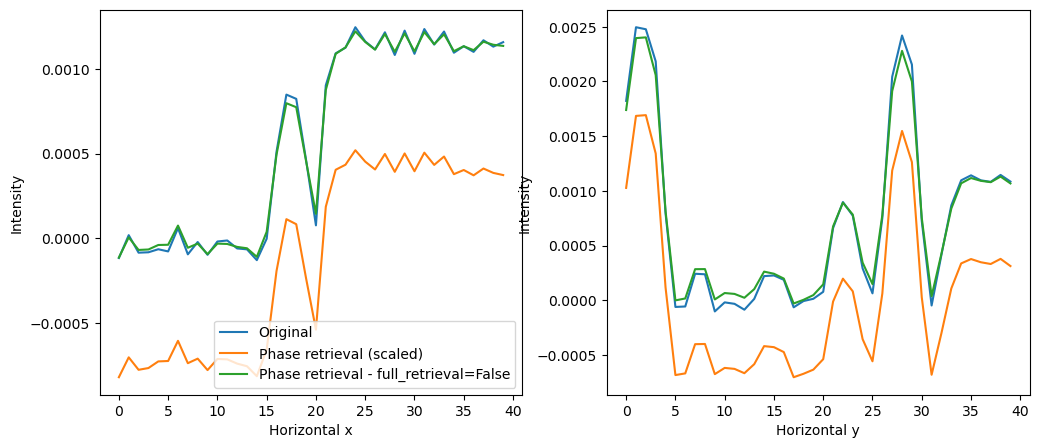

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
ax.plot(recon.array[67,70,50:90])
ax.plot(recon_attenuation.array[67,70,50:90])
ax.plot(recon_filter.array[67,70,50:90])

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.legend(['Original', 'Phase retrieval (scaled)', 'Phase retrieval - full_retrieval=False'])

ax = axs[1]
ax.plot(recon.array[67,50:90,70])
ax.plot(recon_attenuation.array[67,50:90,70])
ax.plot(recon_filter.array[67,50:90,70])

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')

##### Generalised Paganin method

The generalised Paganin method is implemented in CIL following the description in https://iopscience.iop.org/article/10.1088/2040-8986/abbab9 \
When features in the image are close to the Nyquist frequency of the system, a more generalised form of the Pagnin filter can be used which preserves these high frequency features while still boosting SNR. This may have a similar effect to applying an unsharp mask after the normal Paganin phase retrieval. 

In [16]:
# Get data and perform reconstruction without phase retrieval
data = dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()
data.geometry.config.units = 'um'
data.reorder(order='tigre')
data_abs = -1*data.log()
ig = data.geometry.get_ImageGeometry()
fbp =  FBP(data_abs, ig)
recon = fbp.run(verbose=0)

In [17]:
# Run phase retrieval on the raw data and reconstruct
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy)
processor.set_input(data)
thickness = processor.get_output(override_geometry={'propagation_distance':10})
fbp =  FBP(thickness, ig)
recon_thickness = fbp.run(verbose=0)

# calculate mu to get recon_attenuation with the same scaling as the original image
attenuation = thickness*processor.mu
fbp =  FBP(attenuation, ig)
recon_attenuation = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 898.84it/s]


In [18]:
# Run phase retrieval on the raw data using the generalised Paganin method and reconstruct
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, filter_type='generalised_paganin_method')
processor.set_input(data)
thickness_GPM = processor.get_output(override_geometry={'propagation_distance':10})
fbp =  FBP(thickness_GPM, ig)
recon_thickness_GPM = fbp.run(verbose=0)

# calculate mu to get recon_attenuation with the same scaling as the original image
attenuation_GPM = thickness_GPM*processor.mu
fbp =  FBP(attenuation_GPM, ig)
recon_attenuation_GPM = fbp.run(verbose=0)

100%|██████████| 300/300 [00:00<00:00, 892.03it/s]


Text(0, 0.5, 'Intensity')

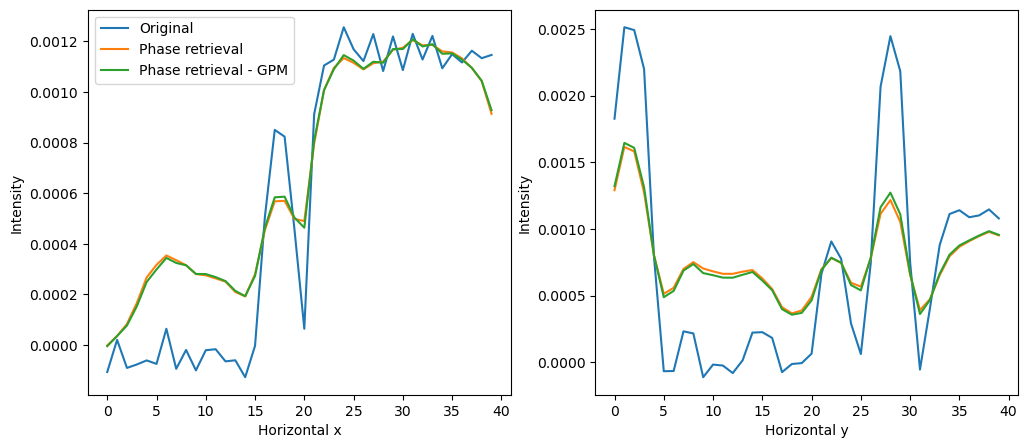

In [19]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
ax.plot(recon.array[67,70,50:90])
ax.plot(recon_attenuation.array[67,70,50:90])
ax.plot(recon_attenuation_GPM.array[67,70,50:90])

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.legend(['Original', 'Phase retrieval', 'Phase retrieval - GPM'])

ax = axs[1]
ax.plot(recon.array[67,50:90,70])
ax.plot(recon_attenuation.array[67,50:90,70])
ax.plot(recon_attenuation_GPM.array[67,50:90,70])

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')

#### TomoBank example

This example uses dataset tomo_00068 from TomoBank https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#wet-sample which can be retrieved using:\
`wget https://g-a0400.fd635.8443.data.globus.org/tomo_00068/tomo_00068.h5`
The data were collected at Syrmep beamline of the Elettra synchotron. A description of the experiment is given in https://link.springer.com/chapter/10.1007/978-3-319-19387-8_70

In [20]:
from cil.io.utilities import HDF5_utilities
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.utilities.display import show2D
from cil.processors import TransmissionAbsorptionConverter, Padder, RingRemover

In [21]:
filename = 'tomo_00068.h5'
# HDF5_utilities.print_metadata(filename=filename, group='/')
data = HDF5_utilities.read(filename=filename, dset_path='/exchange/data')

In [22]:
# parameters from https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#wet-sample
pixel_size = 0.0041 #mm
propagation_distance = 150 #mm
angles = HDF5_utilities.read(filename=filename, dset_path='/exchange/theta')
ag = AcquisitionGeometry.create_Parallel3D(detector_position=[0, propagation_distance, 0], units='mm').set_panel([np.shape(data)[2],np.shape(data)[1]], pixel_size=pixel_size).set_angles(angles)

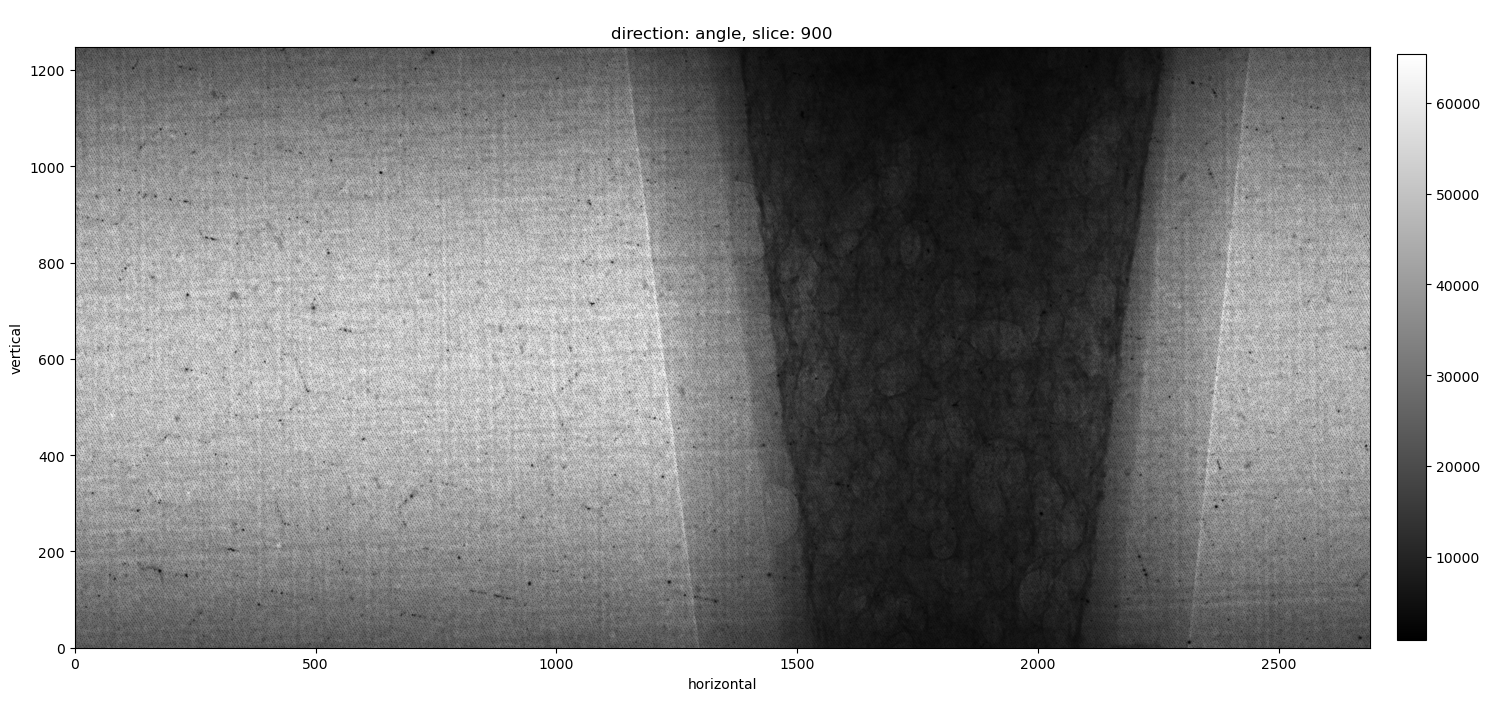

In [23]:
data = AcquisitionData(data, deep_copy=False, geometry = ag)
data.reorder(order='tigre')
show2D(data)

In [24]:
# Run phase retrieval on the raw data
# parameters from https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#wet-sample
delta = 1
beta = 1e-1
energy = 14000

processor = PaganinProcessor(delta=delta, beta=beta, energy=energy)
processor.set_input(data)
thickness = processor.get_output()

# calculate mu to get recon_attenuation with the same scaling as the original image
data_phase = thickness*processor.mu

100%|██████████| 1800/1800 [15:11<00:00,  1.97it/s]


In [25]:
# Run phase retrieval on the raw data
# parameters from https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#wet-sample
delta = 1
beta = 1e-1
energy = 14000

processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, 
                             filter_type='generalised_paganin_method')
processor.set_input(data)
thickness = processor.get_output()

# calculate mu to get recon_attenuation with the same scaling as the original image
data_phase_generalised = thickness*processor.mu

100%|██████████| 1800/1800 [14:37<00:00,  2.05it/s]


In [26]:
vertical_slice = 900
data_phase = data_phase.get_slice(vertical=vertical_slice)

In [27]:
vertical_slice = 900
data_phase_generalised = data_phase_generalised.get_slice(vertical=vertical_slice)

In [28]:
# for comparison just run TransmissionAbsorptionConverter on the same slice
data_slice = data.get_slice(vertical=vertical_slice)

processor = TransmissionAbsorptionConverter()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

In [29]:
# perform some extra processing steps on both datasets
ig = data_slice.geometry.get_ImageGeometry()
padsize = 1000
data_slice = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_slice)
data_phase = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_phase)
data_phase_generalised = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_phase_generalised)

data_slice.geometry.set_centre_of_rotation(1463.5-(data.shape[2]/2), distance_units='pixels')
data_phase.geometry.set_centre_of_rotation(1463.5-(data.shape[2]/2), distance_units='pixels')
data_phase_generalised.geometry.set_centre_of_rotation(1463.5-(data.shape[2]/2), distance_units='pixels')

N_decompositions = 20
wavelet_filter_name = 'db20'
sigma = 5.5

processor = RingRemover(N_decompositions, wavelet_filter_name, sigma) 
processor.set_input(data_slice)
data_slice = processor.get_output()

processor = RingRemover(N_decompositions, wavelet_filter_name, sigma) 
processor.set_input(data_phase)
data_phase = processor.get_output()

processor = RingRemover(N_decompositions, wavelet_filter_name, sigma) 
processor.set_input(data_phase_generalised)
data_phase_generalised = processor.get_output()

fbp =  FBP(data_slice, ig)
recon = fbp.run(verbose=0)

fbp =  FBP(data_phase, ig)
recon_phase = fbp.run(verbose=0)

fbp =  FBP(data_phase_generalised, ig)
recon_phase_g = fbp.run(verbose=0)

Finish Ring Remover
Finish Ring Remover
Finish Ring Remover


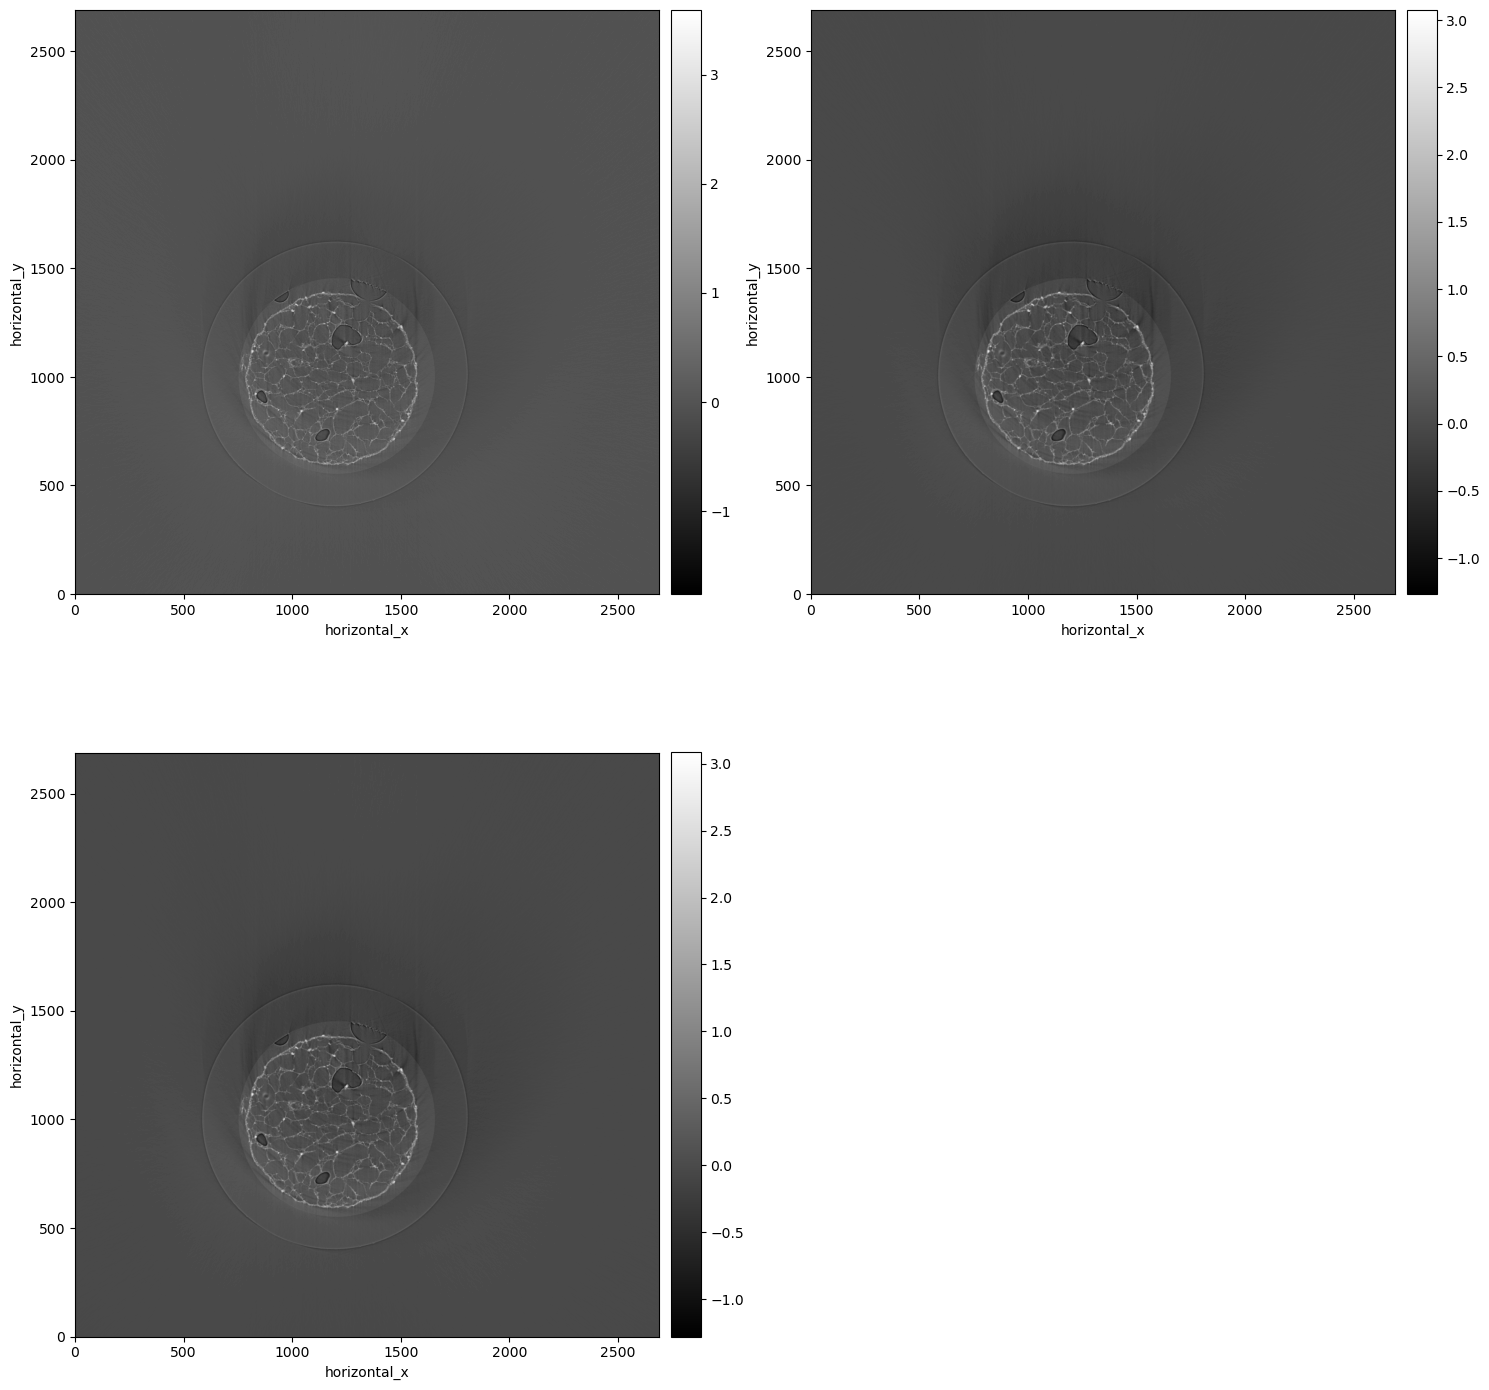

In [30]:
show2D([recon, recon_phase, recon_phase_g])


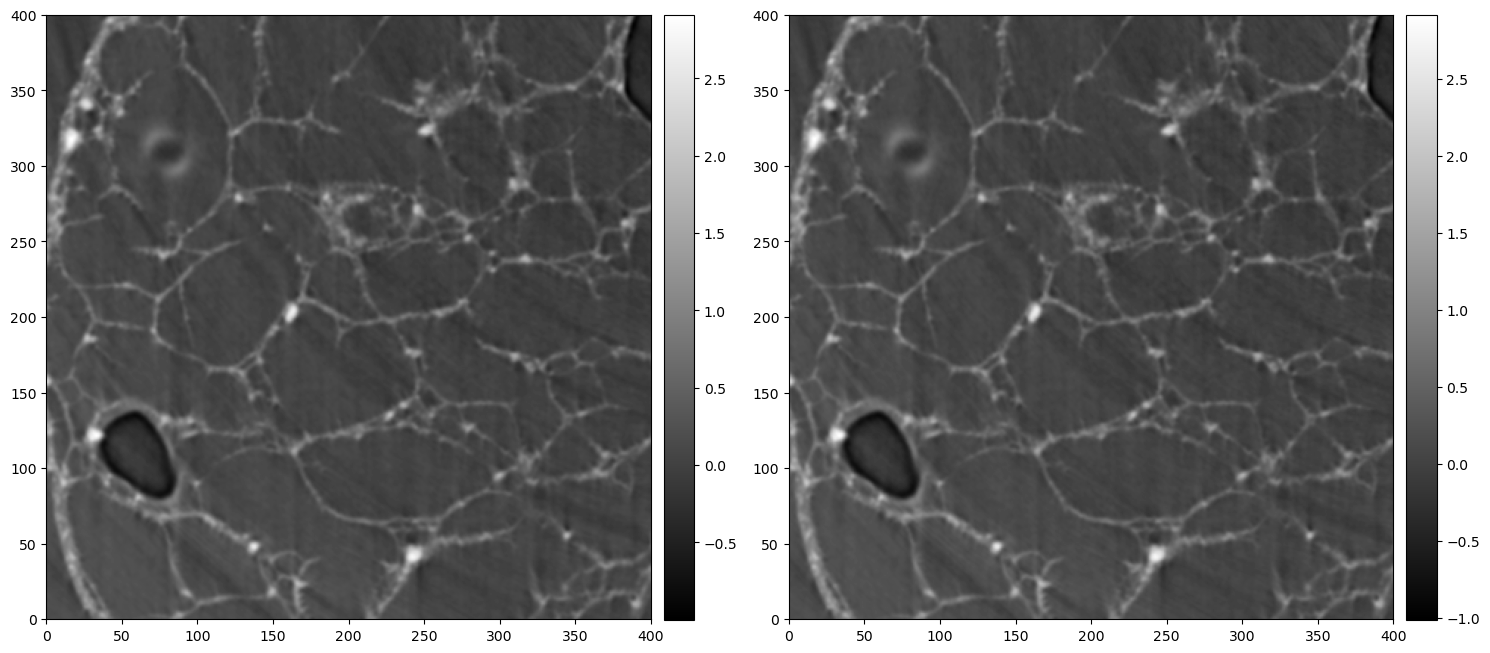

In [31]:

show2D([recon_phase.array[800:1200,800:1200], recon_phase_g.array[800:1200,800:1200]])

Text(0, 0.5, 'Intensity')

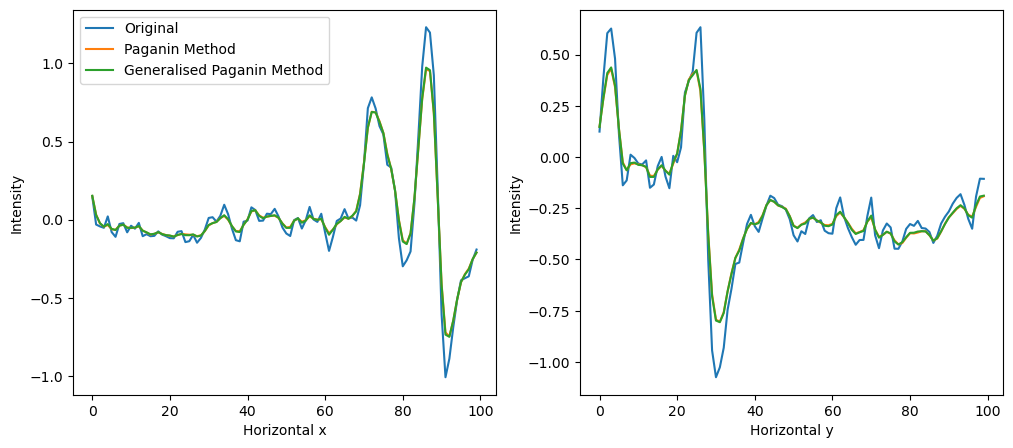

In [32]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]
x = 1200
ax.plot(recon.array[x,1100:1200])
ax.plot(recon_phase.array[x,1100:1200])
ax.plot(recon_phase_g.array[x,1100:1200])

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.legend(['Original', 'Paganin Method', 'Generalised Paganin Method'])

ax = axs[1]
y = 1200
ax.plot(recon.array[1100:1200,y])
ax.plot(recon_phase.array[1100:1200,y])
ax.plot(recon_phase_g.array[1100:1200,y])

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')